In [5]:
#### Creating layer: Number of previous fires

# Take image for a given fire scar

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from rasterio.mask import mask
import rasterio
import geopandas as gpd
from rasterio.plot import show
import rasterio.features
import rasterio.warp
from matplotlib import pyplot
from rasterio.warp import reproject, Resampling
from rasterio.transform import rowcol
from rasterio.windows import Window
from rasterio.merge import merge
from glob import glob
from shapely.geometry import mapping, box
from rasterio.features import geometry_mask
from rasterio.enums import Resampling

base_folder = "Fire_CL-ML_Maule"
output_dir = "merged_rasters"
os.makedirs(output_dir, exist_ok=True)

# perform cropping, padding and centering as in pre-processing 
df = pd.read_excel("FireScar_CL_Summary_1985-2018.xlsx") #excel meta-data file with file names and locations
df = df[df['FireScar'] == 1]  # Filter to just files that have fire scar available
df = df[df['Region_CONAF'] == 'Maule'] # Filter to just Maule
df = df.reset_index()

regions = gpd.read_file("Regiones/Regional.shp")
# Fix coordinate reference system 
regions = regions.to_crs("EPSG:4326")
maule_poly = regions[regions['Region'] == 'Región del Maule'] 
maule_geom = maule_poly.geometry.values

if maule_poly.empty:
    raise ValueError("No 'Maule' region found in shapefile.")


In [45]:
# Merge Mosaic by year, clipped to Maule

for year, group in df.groupby('FireSeason'):
    print(f"Processing year: {year}")

    # Use CRS and resolution from the first valid raster
    first_valid_path = None
    for _, row in group.iterrows():
        path = os.path.join(base_folder, row['FolderLocation'], row['FireScarImgName'])
        if os.path.exists(path):
            first_valid_path = path
            break
    if first_valid_path is None:
        print(f"No valid rasters found for year {year}")
        continue

    with rasterio.open(first_valid_path) as ref_src:
        ref_crs = ref_src.crs
        ref_res = ref_src.res

    # Reproject Maule polygon to raster CRS
    maule_geom_proj = maule_poly.to_crs(ref_crs)
    maule_bounds = maule_geom_proj.total_bounds
    minx, miny, maxx, maxy = maule_bounds

    # Define transform and shape for the base raster
    out_transform = rasterio.transform.from_origin(minx, maxy, ref_res[0], ref_res[1])
    width = int((maxx - minx) / ref_res[0])
    height = int((maxy - miny) / ref_res[1])

    # Create empty base raster filled with 0s
    base_array = np.zeros((height, width), dtype='float32')

    # Mask to only keep data inside Maule
    mask = geometry_mask([mapping(geom) for geom in maule_geom_proj.geometry],
                         transform=out_transform, invert=True,
                         out_shape=(height, width))

    # Loop over fire scar rasters
    for _, row in group.iterrows():
        scar_path = os.path.join(base_folder, row['FolderLocation'], row['FireScarImgName'])
        if not os.path.exists(scar_path):
            print(f"File not found: {scar_path}")
            continue

        try:
            with rasterio.open(scar_path) as src:
                src_data = src.read(1)
                src_data = np.where(src_data > 0, 1, 0).astype('float32')  # Ensure binary

                # Prepare destination array for reprojected image
                reprojected = np.zeros((height, width), dtype='float32')

                reproject(
                    source=src_data,
                    destination=reprojected,
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=out_transform,
                    dst_crs=ref_crs,
                    resampling=Resampling.nearest
                )

                base_array += reprojected  # Add values
        except Exception as e:
            print(f"Could not read {scar_path}: {e}")

    # Cap to 1 for binary result
    base_array = np.clip(base_array, 0, 1)

    # Mask outside Maule, set to nan
    base_array[~mask] = np.nan 

    out_meta = {
        "driver": "GTiff",
        "height": height,
        "width": width,
        "count": 1,
        "dtype": "float32",
        "crs": ref_crs,
        "transform": out_transform,
        "nodata": np.nan
    }

    out_path = os.path.join(output_dir, f"Maule_FireScars_{year}.tif")
    with rasterio.open(out_path, "w", **out_meta) as dest:
        dest.write(base_array, 1)

    print(f"Saved: {out_path}")


Processing year: 1986
Saved: merged_rasters/Maule_FireScars_1986.tif
Processing year: 1987
Saved: merged_rasters/Maule_FireScars_1987.tif
Processing year: 1988
Saved: merged_rasters/Maule_FireScars_1988.tif
Processing year: 1989
Saved: merged_rasters/Maule_FireScars_1989.tif
Processing year: 1990
Saved: merged_rasters/Maule_FireScars_1990.tif
Processing year: 1991
Saved: merged_rasters/Maule_FireScars_1991.tif
Processing year: 1992
Saved: merged_rasters/Maule_FireScars_1992.tif
Processing year: 1993
Saved: merged_rasters/Maule_FireScars_1993.tif
Processing year: 1994
Saved: merged_rasters/Maule_FireScars_1994.tif
Processing year: 1995
Saved: merged_rasters/Maule_FireScars_1995.tif
Processing year: 1996
Saved: merged_rasters/Maule_FireScars_1996.tif
Processing year: 1997
Saved: merged_rasters/Maule_FireScars_1997.tif
Processing year: 1998
Saved: merged_rasters/Maule_FireScars_1998.tif
Processing year: 1999
Saved: merged_rasters/Maule_FireScars_1999.tif
Processing year: 2000
Saved: merge

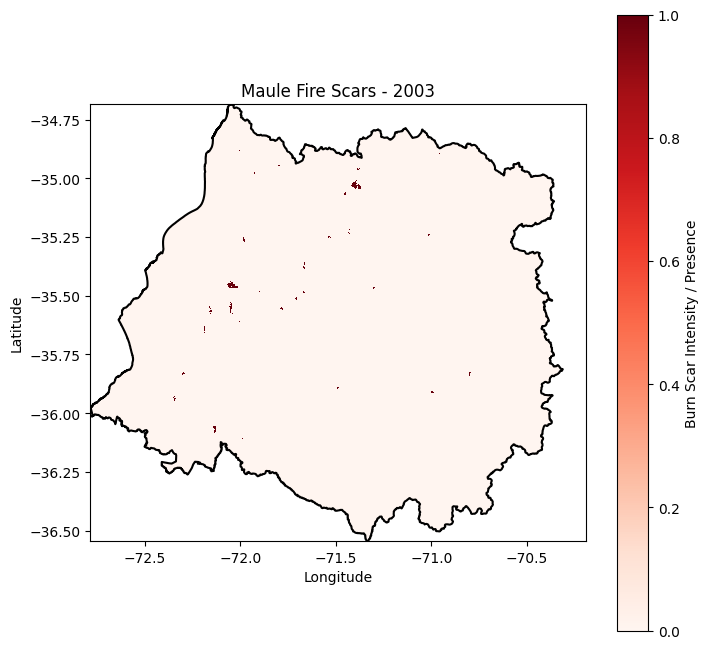

In [50]:
raster_path = "merged_rasters/Maule_FireScars_2010.tif"
# Visualize example
# Open and plot
with rasterio.open(raster_path) as src:
    data = src.read(1) 
    raster_crs = src.crs
    raster_bounds = src.bounds

    maule_poly = maule_poly.to_crs(raster_crs)

    extent = [raster_bounds.left, raster_bounds.right, raster_bounds.bottom, raster_bounds.top] # For formating plot

    plt.figure(figsize=(8, 8))
    plt.imshow(data, cmap='Reds', interpolation='none', extent=[raster_bounds.left, raster_bounds.right, raster_bounds.bottom, raster_bounds.top])
    plt.colorbar(label="Burn Scar Intensity / Presence")
    plt.title("Maule Fire Scars - 2003")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

    # Plot Maule border
    maule_poly.boundary.plot(ax=plt.gca(), edgecolor='black', linewidth=1.5)

    plt.grid(False)
    plt.show()
    

In [ ]:
### Now, create a 

True

In [27]:
raster_crs

CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]')

In [52]:
# 10 year fire history

# Create merged mosaic of year by adding previous 10 years, excluding current year (represent # previous fires in past 10 years)
output_dir = "prev10_rasters"
input_dir = 'merged_rasters'
os.makedirs(output_dir, exist_ok=True)

# Get sorted list of available years
tif_files = sorted(glob(os.path.join(input_dir, "Maule_FireScars_*.tif")))
available_years = [int(os.path.basename(f).split('_')[-1].split('.')[0]) for f in tif_files]

# Map from year to filepath
year_to_path = {int(os.path.basename(f).split('_')[-1].split('.')[0]): f for f in tif_files}

# Loop over years and create "previous 10 years" raster
for year in available_years:
    # Get the previous 10 years
    prev_years = [y for y in range(year - 10, year) if y in year_to_path]
    if not prev_years:
        print(f"Skipping {year}: No previous rasters available.")
        continue

    print(f"Processing: {year} (using {len(prev_years)} previous years)")

    # Open the first raster to get metadata and shape
    with rasterio.open(year_to_path[prev_years[0]]) as src:
        out_meta = src.meta.copy()
        data_sum = src.read(1).astype('float32')
        data_sum[np.isnan(data_sum)] = 0  # Treat NaNs as 0

    # Sum the other rasters
    for y in prev_years[1:]:
        with rasterio.open(year_to_path[y]) as src:
            data = src.read(1).astype('float32')
            data[np.isnan(data)] = 0
            data_sum += data

    # Keep NaNs where they were originally masked (i.e., outside Maule)
    with rasterio.open(year_to_path[prev_years[0]]) as ref_src:
        mask = ref_src.read(1)
        data_sum[np.isnan(mask)] = np.nan

    # Save the result
    out_path = os.path.join(output_dir, f"Maule_Prev10FireScars_{year}.tif")
    out_meta.update({"dtype": "float32", "nodata": np.nan})
    with rasterio.open(out_path, "w", **out_meta) as dest:
        dest.write(data_sum, 1)

    print(f"Saved: {out_path}")


Skipping 1986: No previous rasters available.
Processing: 1987 (using 1 previous years)
Saved: prev10_rasters/Maule_Prev10FireScars_1987.tif
Processing: 1988 (using 2 previous years)
Saved: prev10_rasters/Maule_Prev10FireScars_1988.tif
Processing: 1989 (using 3 previous years)
Saved: prev10_rasters/Maule_Prev10FireScars_1989.tif
Processing: 1990 (using 4 previous years)
Saved: prev10_rasters/Maule_Prev10FireScars_1990.tif
Processing: 1991 (using 5 previous years)
Saved: prev10_rasters/Maule_Prev10FireScars_1991.tif
Processing: 1992 (using 6 previous years)
Saved: prev10_rasters/Maule_Prev10FireScars_1992.tif
Processing: 1993 (using 7 previous years)
Saved: prev10_rasters/Maule_Prev10FireScars_1993.tif
Processing: 1994 (using 8 previous years)
Saved: prev10_rasters/Maule_Prev10FireScars_1994.tif
Processing: 1995 (using 9 previous years)
Saved: prev10_rasters/Maule_Prev10FireScars_1995.tif
Processing: 1996 (using 10 previous years)
Saved: prev10_rasters/Maule_Prev10FireScars_1996.tif
Pro

In [17]:
# 30 year fire history: Frequency of fire occurrence (as a fraction)
# Constructed using Merged files from previous step

# Create merged mosaic of year by dividing the total number of fires by the total number of years considered
output_dir = "fire_history_rasters_30yr"
input_dir = 'merged_rasters'
os.makedirs(output_dir, exist_ok=True)

# Get sorted list of available years
tif_files = sorted(glob(os.path.join(input_dir, "Maule_FireScars_*.tif")))
available_years = [int(os.path.basename(f).split('_')[-1].split('.')[0]) for f in tif_files]

# Map from year to filepath
year_to_path = {int(os.path.basename(f).split('_')[-1].split('.')[0]): f for f in tif_files}

# Loop over years and create "previous 10 years" frequency raster
for year in available_years:
    # Get the previous 10 years
    prev_years = [y for y in range(year - 30, year) if y in year_to_path]
    if not prev_years:
        print(f"Skipping {year}: No previous rasters available.")
        continue

    print(f"Processing: {year} (using {len(prev_years)} previous years)")

    # Open the first raster to get metadata and initialize fire occurrence count
    with rasterio.open(year_to_path[prev_years[0]]) as src:
        out_meta = src.meta.copy()
        data_freq = np.zeros(src.shape, dtype='float32')  # Initialize frequency to 0
        mask = src.read(1)  # Read mask to preserve NaN areas
        data_freq[np.isnan(mask)] = np.nan  # Set NaN areas to NaN in the result

    # Count occurrences of fire in each raster
    for y in prev_years:
        with rasterio.open(year_to_path[y]) as src:
            data = src.read(1).astype('float32')
            data[np.isnan(data)] = 0  # Treat NaNs as 0 (no fire)
            data_freq += (data > 0).astype('float32')  # Increment frequency for pixels with fire

    # Compute the frequency a
    data_freq /= len(prev_years)  

    # Save the result as a frequency map 
    out_path = os.path.join(output_dir, f"Maule_FireFreq_{year}.tif")
    out_meta.update({"dtype": "float32", "nodata": np.nan})
    with rasterio.open(out_path, "w", **out_meta) as dest:
        dest.write(data_freq, 1)

    print(f"Saved: {out_path}")


Skipping 1986: No previous rasters available.
Processing: 1987 (using 1 previous years)
Saved: fire_history_rasters_30yr/Maule_FireFreq_1987.tif
Processing: 1988 (using 2 previous years)
Saved: fire_history_rasters_30yr/Maule_FireFreq_1988.tif
Processing: 1989 (using 3 previous years)
Saved: fire_history_rasters_30yr/Maule_FireFreq_1989.tif
Processing: 1990 (using 4 previous years)
Saved: fire_history_rasters_30yr/Maule_FireFreq_1990.tif
Processing: 1991 (using 5 previous years)
Saved: fire_history_rasters_30yr/Maule_FireFreq_1991.tif
Processing: 1992 (using 6 previous years)
Saved: fire_history_rasters_30yr/Maule_FireFreq_1992.tif
Processing: 1993 (using 7 previous years)
Saved: fire_history_rasters_30yr/Maule_FireFreq_1993.tif
Processing: 1994 (using 8 previous years)
Saved: fire_history_rasters_30yr/Maule_FireFreq_1994.tif
Processing: 1995 (using 9 previous years)
Saved: fire_history_rasters_30yr/Maule_FireFreq_1995.tif
Processing: 1996 (using 10 previous years)
Saved: fire_history_

In [15]:
raster_path = "fire_history_rasters_30yr/Maule_FireFreq_2010.tif"

with rasterio.open(raster_path) as src:
    data = src.read(1) 
    print(np.nanmax(data))
    print(np.nanmin(data))
    print(np.nanmean(data))
    print(data.shape)

0.16666667
0.0
0.0006838777
(6898, 9180)


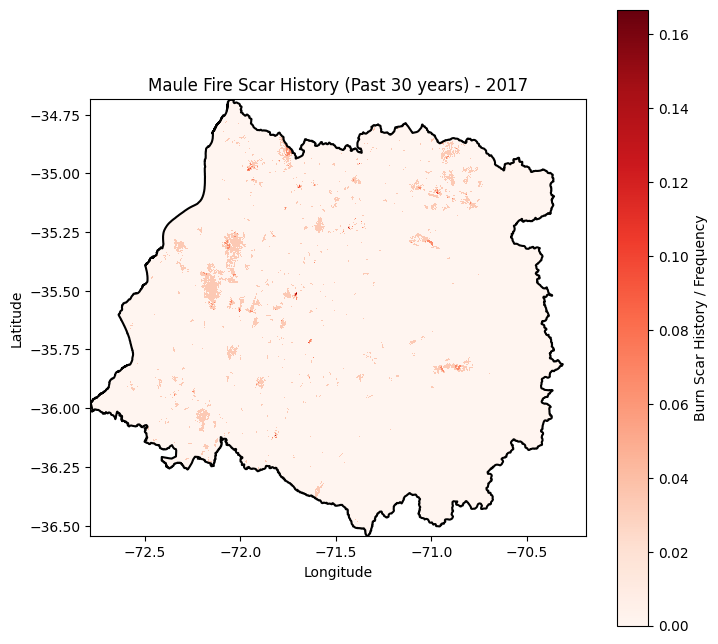

In [21]:
raster_path = "fire_history_rasters_30yr/Maule_FireFreq_2017.tif"
# Visualize example
# Open and plot
with rasterio.open(raster_path) as src:
    data = src.read(1) 
    raster_crs = src.crs
    raster_bounds = src.bounds

    maule_poly = maule_poly.to_crs(raster_crs)

    extent = [raster_bounds.left, raster_bounds.right, raster_bounds.bottom, raster_bounds.top] # For formating plot

    plt.figure(figsize=(8, 8))
    plt.imshow(data, cmap='Reds', interpolation='none', extent=[raster_bounds.left, raster_bounds.right, raster_bounds.bottom, raster_bounds.top])
    plt.colorbar(label="Burn Scar History / Frequency")
    plt.title("Maule Fire Scar History (Past 30 years) - 2017")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

    # Plot Maule border
    maule_poly.boundary.plot(ax=plt.gca(), edgecolor='black', linewidth=1.5)

    plt.grid(False)
    plt.show()

In [ ]:
### Now create merged severity maps

# Merge Mosaic by year, clipped to Maule
output_dir = "merged_severity_rasters"
for year, group in df.groupby('FireSeason'):
    print(f"Processing year: {year}")

    # Use CRS and resolution from the first valid raster
    first_valid_path = None
    for _, row in group.iterrows():
        path = os.path.join(base_folder, row['FolderLocation'], row['SeverityImgName'])
        if os.path.exists(path):
            first_valid_path = path
            break
    if first_valid_path is None:
        print(f"No valid rasters found for year {year}")
        continue

    with rasterio.open(first_valid_path) as ref_src:
        ref_crs = ref_src.crs
        ref_res = ref_src.res

    # Reproject Maule polygon to raster CRS
    maule_geom_proj = maule_poly.to_crs(ref_crs)
    maule_bounds = maule_geom_proj.total_bounds
    minx, miny, maxx, maxy = maule_bounds

    # Define transform and shape for the base raster
    out_transform = rasterio.transform.from_origin(minx, maxy, ref_res[0], ref_res[1])
    width = int((maxx - minx) / ref_res[0])
    height = int((maxy - miny) / ref_res[1])

    # Create empty base raster filled with 0s
    base_array = np.zeros((height, width), dtype='float32')

    # Mask to only keep data inside Maule
    mask = geometry_mask([mapping(geom) for geom in maule_geom_proj.geometry],
                         transform=out_transform, invert=True,
                         out_shape=(height, width))

    # Loop over fire scar rasters
    for _, row in group.iterrows():
        scar_path = os.path.join(base_folder, row['FolderLocation'], row['FireScarImgName'])
        if not os.path.exists(scar_path):
            print(f"File not found: {scar_path}")
            continue

        try:
            with rasterio.open(scar_path) as src:
                src_data = src.read(1)

                # Prepare destination array for reprojected image
                reprojected = np.zeros((height, width), dtype='float32')

                reproject(
                    source=src_data,
                    destination=reprojected,
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=out_transform,
                    dst_crs=ref_crs,
                    resampling=Resampling.nearest
                )

                base_array += reprojected  # Add values
        except Exception as e:
            print(f"Could not read {scar_path}: {e}")

    # Cap to 1 for binary result
    base_array = np.clip(base_array, 0, 1)

    # Mask outside Maule, set to nan
    base_array[~mask] = np.nan 

    out_meta = {
        "driver": "GTiff",
        "height": height,
        "width": width,
        "count": 1,
        "dtype": "float32",
        "crs": ref_crs,
        "transform": out_transform,
        "nodata": np.nan
    }

    out_path = os.path.join(output_dir, f"Maule_Severity_{year}.tif")
    with rasterio.open(out_path, "w", **out_meta) as dest:
        dest.write(base_array, 1)

    print(f"Saved: {out_path}")


In [11]:
### Time since last fire

import os
import numpy as np
import rasterio

# Path to your folder
folder_path = "merged_rasters"

# Get a sorted list of years
files = sorted([f for f in os.listdir(folder_path) if f.endswith('.tif')])
years = [int(f.split('_')[-1].split('.')[0]) for f in files]
files_by_year = dict(zip(years, files))

# Initialize storage for "time since fire"
time_since_fire = None

# Output folder (optional)
output_folder = "capas/incendio/time_since_last_fire"
os.makedirs(output_folder, exist_ok=True)

# Loop through years in order
for i, year in enumerate(sorted(years)):
    file_path = os.path.join(folder_path, files_by_year[year])

    with rasterio.open(file_path) as src:
        fire_mask = src.read(1)
        meta = src.meta.copy()

        if time_since_fire is None:
            # Initialize: if fire, 0; if no fire, set to a large number (or np.nan)
            time_since_fire = np.where(fire_mask == 1, 0, np.nan)
        else:
            # If fire, reset to 0; otherwise, increment previous value by 1
            time_since_fire = np.where(fire_mask == 1, 0,
                                       np.where(np.isnan(time_since_fire), np.nan, time_since_fire + 1))

        # Save the time_since_fire layer
        out_path = os.path.join(output_folder, f"time_since_last_fire_{year}.tif")
        meta.update(dtype=rasterio.float32, nodata=np.nan)
        with rasterio.open(out_path, 'w', **meta) as dst:
            dst.write(time_since_fire.astype(np.float32), 1)

        print(f"Saved: {out_path}")


Saved: capas/incendio/time_since_last_fire/time_since_last_fire_1986.tif
Saved: capas/incendio/time_since_last_fire/time_since_last_fire_1987.tif
Saved: capas/incendio/time_since_last_fire/time_since_last_fire_1988.tif
Saved: capas/incendio/time_since_last_fire/time_since_last_fire_1989.tif
Saved: capas/incendio/time_since_last_fire/time_since_last_fire_1990.tif
Saved: capas/incendio/time_since_last_fire/time_since_last_fire_1991.tif
Saved: capas/incendio/time_since_last_fire/time_since_last_fire_1992.tif
Saved: capas/incendio/time_since_last_fire/time_since_last_fire_1993.tif
Saved: capas/incendio/time_since_last_fire/time_since_last_fire_1994.tif
Saved: capas/incendio/time_since_last_fire/time_since_last_fire_1995.tif
Saved: capas/incendio/time_since_last_fire/time_since_last_fire_1996.tif
Saved: capas/incendio/time_since_last_fire/time_since_last_fire_1997.tif
Saved: capas/incendio/time_since_last_fire/time_since_last_fire_1998.tif
Saved: capas/incendio/time_since_last_fire/time_sin

In [13]:
import os
import numpy as np
import rasterio

# Folder containing the time_since_last_fire rasters
folder_path = "capas/incendio/time_since_last_fire"
output_folder = "capas/incendio/time_since_last_fire"  # You can overwrite or save to another folder

# Get a sorted list of the time_since_last_fire files
files = sorted([f for f in os.listdir(folder_path) if f.endswith('.tif')])

# Loop through each file in the folder
for file in files:
    file_path = os.path.join(folder_path, file)

    # Open the raster file using rasterio
    with rasterio.open(file_path) as src:
        # Read the raster data
        fire_data = src.read(1)
        meta = src.meta.copy()

        # Replace the 0 values with NaN
        fire_data[fire_data == 0] = np.nan

        # Update the meta to handle NaN correctly
        meta.update(dtype=rasterio.float32, nodata=np.nan)

        # Save the modified raster back to the file
        output_path = os.path.join(output_folder, file)
        with rasterio.open(output_path, 'w', **meta) as dst:
            dst.write(fire_data.astype(np.float32), 1)

        print(f"Rewritten: {output_path}")


Rewritten: capas/incendio/time_since_last_fire/time_since_last_fire_1986.tif
Rewritten: capas/incendio/time_since_last_fire/time_since_last_fire_1987.tif
Rewritten: capas/incendio/time_since_last_fire/time_since_last_fire_1988.tif
Rewritten: capas/incendio/time_since_last_fire/time_since_last_fire_1989.tif
Rewritten: capas/incendio/time_since_last_fire/time_since_last_fire_1990.tif
Rewritten: capas/incendio/time_since_last_fire/time_since_last_fire_1991.tif
Rewritten: capas/incendio/time_since_last_fire/time_since_last_fire_1992.tif
Rewritten: capas/incendio/time_since_last_fire/time_since_last_fire_1993.tif
Rewritten: capas/incendio/time_since_last_fire/time_since_last_fire_1994.tif
Rewritten: capas/incendio/time_since_last_fire/time_since_last_fire_1995.tif
Rewritten: capas/incendio/time_since_last_fire/time_since_last_fire_1996.tif
Rewritten: capas/incendio/time_since_last_fire/time_since_last_fire_1997.tif
Rewritten: capas/incendio/time_since_last_fire/time_since_last_fire_1998.tif

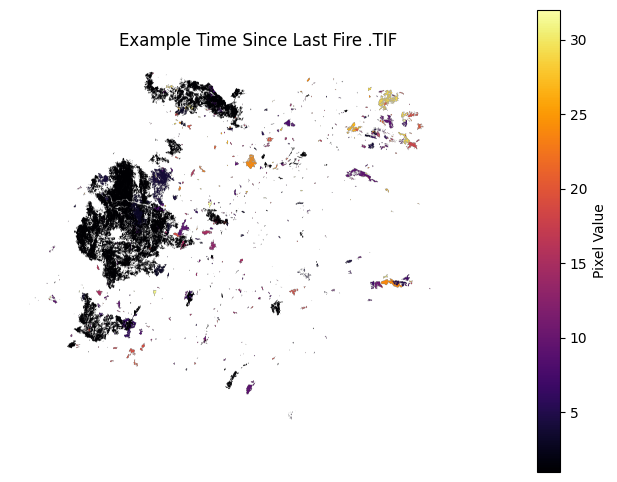

In [18]:
# Visualize an example
import matplotlib.pyplot as plt
import rasterio
tif_path = "capas/incendio/time_since_last_fire/time_since_last_fire_2018.tif"  
#tif_path = "merged_rasters/Maule_FireScars_2017.tif"
# Open and display the image
with rasterio.open(tif_path) as src:
    image = src.read(1) 
    plt.figure(figsize=(8, 6))
    plt.imshow(image, cmap='inferno')  
    plt.title("Example Time Since Last Fire .TIF")
    plt.colorbar(label="Pixel Value")
    plt.axis('off')
    plt.show()

In [23]:
### Merged ignition point maps

import rasterio
from rasterio.transform import from_origin
from rasterio.features import rasterize
from scipy.ndimage import gaussian_filter

# Parameters
resolution = 30  # meters
sigma_meters = 90  # uncertainty
sigma_px = sigma_meters / resolution

maule_utm = maule_poly.to_crs("EPSG:32719")  # UTM Zone 19S

# Get the bounds in UTM (meters)
minx, miny, maxx, maxy = maule_utm.total_bounds

# Create a bounding box around Maule for raster size

width = int((maxx - minx) / resolution)  # Pixels per row (width)
height = int((maxy - miny) / resolution)  # Pixels per column (height)


# Print out the bounds and check
print(f"Bounds in UTM: {minx}, {miny}, {maxx}, {maxy}")
print(f"Raster grid: width={width}, height={height}")

# Create affine transform for raster (Top-left origin)
transform = from_origin(minx, maxy, resolution, resolution)



Bounds in UTM: 158613.691091678, 5953220.914170118, 381493.9242370692, 6157731.384568213
Raster grid: width=7429, height=6817


In [24]:

# Create output directory
ignition_output_dir = "capas/incendio/ignition_probability_maps"
os.makedirs(ignition_output_dir, exist_ok=True)

# Convert ignition points into GeoDataFrame
ignition_gdf = gpd.GeoDataFrame(
    df, 
    geometry=gpd.points_from_xy(df['Longitude [°]'], df['Latitude [°]']),
    crs="EPSG:4326"
)

# Reproject points to match Maule shapefile
ignition_gdf = ignition_gdf.to_crs(maule_poly.crs)

# Loop through each year
for year in sorted(ignition_gdf['FireSeason'].unique()):
    points_year = ignition_gdf[ignition_gdf['FireSeason'] == year]

    if points_year.empty:
        print(f"No ignition points for {year}")
        continue

    # Rasterize ignition points (each ignition = 1)

    points_year_utm = points_year.to_crs("EPSG:32719")

    # Now rasterize the points
    shapes = ((geom, 1) for geom in points_year_utm.geometry)
    ignition_raster = rasterize(
        shapes=shapes,
        out_shape=(height, width),
        transform=transform,
        fill=0,
        dtype=np.float32
        )
    

    # Apply Gaussian smoothing
    ignition_prob = gaussian_filter(ignition_raster, sigma=sigma_px)

    # Save ignition probability map
    out_path = os.path.join(ignition_output_dir, f"ignition_prob_{year}.tif")
    meta = {
        'driver': 'GTiff',
        'height': height,
        'width': width,
        'count': 1,
        'dtype': 'float32',
        'crs': maule_poly.crs,
        'transform': transform,
        'nodata': 0
    }

    with rasterio.open(out_path, 'w', **meta) as dst:
        dst.write(ignition_prob, 1)

    print(f"Saved ignition map for {year}: {out_path}")



Saved ignition map for 1986: capas/incendio/ignition_probability_maps/ignition_prob_1986.tif
Saved ignition map for 1987: capas/incendio/ignition_probability_maps/ignition_prob_1987.tif
Saved ignition map for 1988: capas/incendio/ignition_probability_maps/ignition_prob_1988.tif
Saved ignition map for 1989: capas/incendio/ignition_probability_maps/ignition_prob_1989.tif
Saved ignition map for 1990: capas/incendio/ignition_probability_maps/ignition_prob_1990.tif
Saved ignition map for 1991: capas/incendio/ignition_probability_maps/ignition_prob_1991.tif
Saved ignition map for 1992: capas/incendio/ignition_probability_maps/ignition_prob_1992.tif
Saved ignition map for 1993: capas/incendio/ignition_probability_maps/ignition_prob_1993.tif
Saved ignition map for 1994: capas/incendio/ignition_probability_maps/ignition_prob_1994.tif
Saved ignition map for 1995: capas/incendio/ignition_probability_maps/ignition_prob_1995.tif
Saved ignition map for 1996: capas/incendio/ignition_probability_maps/

In [26]:
np.mean(ignition_raster)

9.872937e-07

0.0
1.9153547e-06
0.017684886


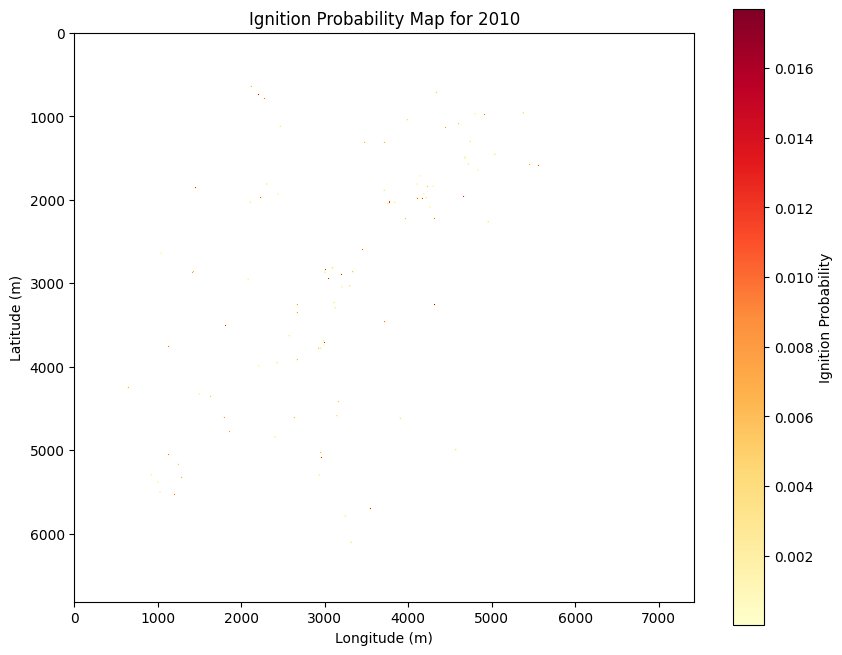

In [29]:
prob_map_path = "capas/incendio/ignition_probability_maps/ignition_prob_2017.tif"

# Open the raster file using rasterio
with rasterio.open(prob_map_path) as src:
    prob_map = src.read(1)  # Read the first (and only) band of the raster
    print(np.nanmin(prob_map))
    print(np.nanmean(prob_map))
    print(np.nanmax(prob_map))
    # Mask out the nodata values (assuming 0 is the nodata value)
    prob_map[prob_map == src.nodata] = np.nan

# Plot the map using matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(prob_map, cmap='YlOrRd', interpolation='nearest')
plt.colorbar(label='Ignition Probability')
plt.title(f"Ignition Probability Map for 2010")
plt.xlabel("Longitude (m)")
plt.ylabel("Latitude (m)")
plt.show()

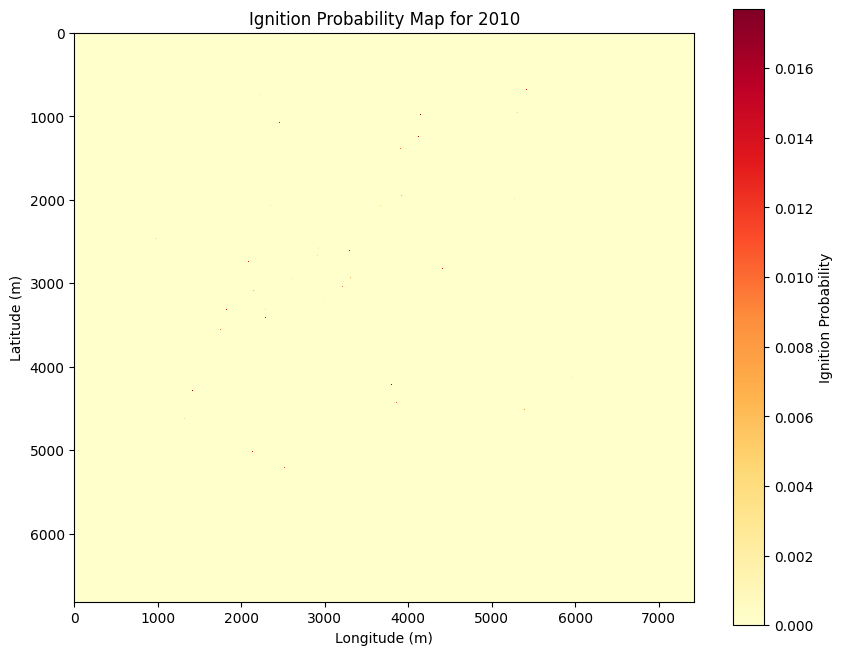

In [30]:


# Path to the ignition probability map for the year 2010
prob_map_path = "capas/incendio/ignition_probability_maps/ignition_prob_2010.tif"

# Open the raster file using rasterio
with rasterio.open(prob_map_path) as src:
    prob_map = src.read(1)  # Read the first (and only) band of the raster

# Plot the raster data
plt.figure(figsize=(10, 8))
plt.imshow(prob_map, cmap='YlOrRd', interpolation='nearest')
plt.colorbar(label='Ignition Probability')
plt.title(f"Ignition Probability Map for 2010")
plt.xlabel("Longitude (m)")
plt.ylabel("Latitude (m)")

# Enable interactive mode for zooming
plt.ion()
plt.show()

# The plot should now allow you to zoom in and out manually with the mouse scroll
